In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

import torch
from torch.utils.data import Dataset, DataLoader

from data import H5Dataset
from models import FCN
from oc import OptControl
from torch_pendulum import Pendulum

Given running cost $g(x_t,u_t)$ and terminal cost $h(x_T)$ the finite horizon $(t=0 \ldots T)$ optimal control problem seeks to find the optimal control, 
$$u^*_{1:T} = \text{argmin}_{u_{1:T}} L(x_{1:T},u_{1:T})$$ 
$$u^*_{1:T} = \text{argmin}_{u_{1:T}} h(x_T) + \sum_{t=0}^T g(x_t,u_t)$$
subject to the dynamics constraint: $x_{t+1} = f(x_t,u_t)$.

This notebook provides a dirty, brute forcing solution to problems of this form, using the inverted pendulum as an example, and assuming dynamics are not know a-priori. First, we gather state, actions, next state pairs, and use these to train a surrogate neural network dynamics model, $x_{t+1} \sim \hat{f}(x_t,u_t)$, approximating the true dynamics $f$.

We'll then set up a shooting-based trajectory optimisation problem, rolling out using the surrgoate dynamics $\hat{f}$ for a sequence of controls $u^*_{1:T}$, evaluate the cost, then take gradient steps to minimise this, adjusting the values of the control. We'll use pytorch and Adam to accomplish this. We'll do this in a continuous control setting, but note that this is a practically infeasible control strategy, because solving this sort of optimisation online (and with any convergence guarantees) within the bandwidth of an inverted pendulum is a stretch.  

In [2]:
# NN parameters
Nsamples = 10000
epochs = 500

latent_dim = 1024
batch_size = 8
lr = 3e-4

# Torch environment wrapping gym pendulum
torch_env = Pendulum()

# Test parameters
Nsteps = 100

In [3]:
# Set up model (fully connected neural network)

model = FCN(latent_dim=latent_dim,d=torch_env.d,ud=torch_env.ud)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [4]:
# Load previously trained model
model.load_state_dict(torch.load('./fcn.npy'))

<All keys matched successfully>

In [ ]:
# Or gather some training data
states_, actions, states = torch_env.get_data(Nsamples)

dset = H5Dataset(np.array(states_),np.array(actions),np.array(states))
sampler = DataLoader(dset, batch_size=batch_size, shuffle=True)

In [ ]:
# and train model

losses = []
for epoch in range(epochs):
    
    batch_losses = []
    for states_,actions,states in sampler:
        
        recon_x = model(states_,actions)
        loss = model.loss_fn(recon_x,states)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    losses.append(np.mean(batch_losses))
    plt.cla()
    plt.semilogy(losses)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
torch.save(model.state_dict(),'./fcn.npy')

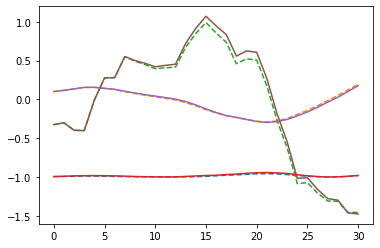

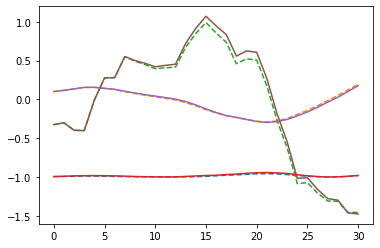

In [5]:
# Test model rollouts - looks reasonable

states = []
_states = []

s = torch_env.env.reset()
states.append(s)
_states.append(s.copy())
for i in range(30):
    a = torch_env.env.action_space.sample()
    s,r,_,_ = torch_env.env.step(a) # take a random action
    states.append(s)
    
    # roll-out with model
    _s = model(torch.from_numpy(_states[-1]).float().reshape(1,-1),torch.from_numpy(a).float().reshape(1,-1))
    _states.append(_s.detach().numpy())
    
    plt.cla()
    plt.plot(np.array(states),'--')
    plt.plot(np.vstack(_states))
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

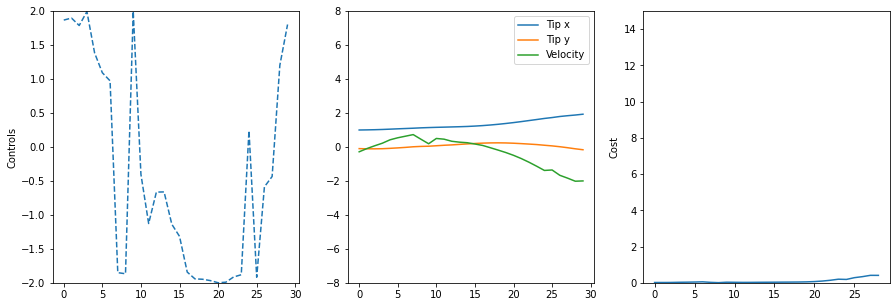

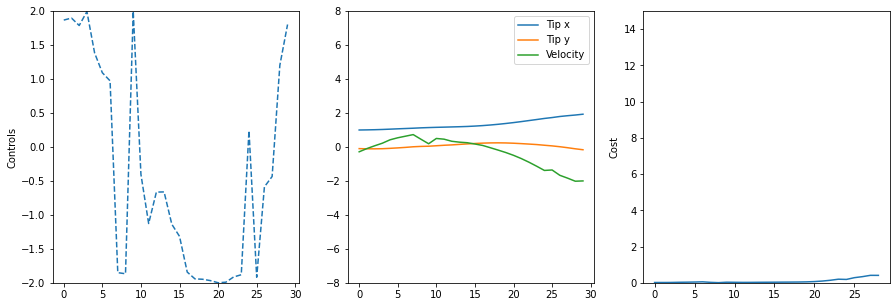

In [21]:
# Set up optimal controller
controller = OptControl(model.dynamics, torch_env.running_cost, torch_env.term_cost, u_dim=torch_env.ud, umax=torch_env.umax, horizon=30,lr=1e-1)

# Uncomment to use true dynamics
# controller = OptControl(torch_env.dynamics, torch_env.running_cost, torch_env.term_cost, u_dim=torch_env.ud, umax=torch_env.umax, horizon=30,lr=1e-1)

# Test controller
plt.figure(figsize=(15,5))
s = torch_env.env.reset()
for i in range(Nsteps):
    
    u,states,cost,costs = controller.minimize(torch.from_numpy(s).reshape(1,-1).float(),Nsteps=5) #OC
    
    s,r,_,_ = torch_env.env.step(u[:,0].detach().numpy()) # take a random action
    
    torch_env.env.render()
    
    plt.clf()
    plt.subplot(1,3,1)
    plt.plot(u.detach().numpy().T,'--')
    plt.ylim(-2,2)
    plt.ylabel('Controls')
    plt.subplot(1,3,2)
    plt.plot(np.squeeze(torch.stack(states).detach().numpy()))
    plt.legend({'Tip x','Tip y','Velocity'})
    plt.ylim(-8,8)
    plt.subplot(1,3,3)
    plt.plot(np.squeeze(torch.stack(costs).detach().numpy()))
    plt.ylabel('Cost')
    plt.ylim(0,15)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [ ]:
torch_env.env.close()